# Requirements & Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sklearn
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision.models as models
import tifffile as tiff
import numpy as np
import os
import itertools
import imageio
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
from itertools import product
from prettytable import PrettyTable, from_csv
import json
import pickle
import csv
import pandas as pd
import scipy.stats

In [ ]:
# Set the path to the preprocessed data directory
data_dir = '../../data/Patches/'

# Step 1: Training data preparation

## 1.1 Load patches


In [ ]:
# Set the path to the satellite image patches directory
sat_dir = os.path.join(data_dir, 'sat_patches')

# Set the path to the population patches directory
pop_dir = os.path.join(data_dir, 'pop_patches')

# Get the file paths of the satellite image patches
file_paths = [os.path.join(sat_dir, file_name) for file_name in os.listdir(sat_dir)]

## 1.2 Split data into training, validation and test sets

This code splits the satellite image patches into three sets: training, validation, and testing. The split ratio is 70-10-20. The corresponding population patches for each satellite image patch are also copied to the respective split directories.

In [ ]:
# Shuffle the file paths
random.shuffle(file_paths)

# Split the data into training, validation, and testing sets
train_paths, test_paths = train_test_split(file_paths, test_size=0.2, random_state=42)
train_paths, val_paths = train_test_split(train_paths, test_size=0.125, random_state=42)

## 1.3 Save split data as separate files


In [ ]:
# Create the directories to save the split data
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(os.path.join(train_dir, 'sat_patches'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'pop_patches'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'sat_patches'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'pop_patches'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'sat_patches'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'pop_patches'), exist_ok=True)

# Copy the satellite image patches to the respective split directories
for file_path, dest_dir in zip(train_paths, [train_dir] * len(train_paths)):
    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_dir, 'sat_patches', file_name)
    np.save(dest_path, np.load(file_path))

for file_path, dest_dir in zip(val_paths, [val_dir] * len(val_paths)):
    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_dir, 'sat_patches', file_name)
    np.save(dest_path, np.load(file_path))

for file_path, dest_dir in zip(test_paths, [test_dir] * len(test_paths)):
    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_dir, 'sat_patches', file_name)
    np.save(dest_path, np.load(file_path))

# Copy the population patches to the respective split directories
for split_dir, split_paths in zip([train_dir, val_dir, test_dir], [train_paths, val_paths, test_paths]):
    pop_split_dir = os.path.join(split_dir, 'pop_patches')
    os.makedirs(pop_split_dir, exist_ok=True)
    
    for file_path in split_paths:
        pop_file_path = os.path.join(pop_dir, os.path.basename(file_path).replace('sat_patch', 'pop_patch'))
        pop_dest_path = os.path.join(pop_split_dir, os.path.basename(pop_file_path))
        np.save(pop_dest_path, np.load(pop_file_path))


In [ ]:
keywords = ["kyiv", "dnipro", "lviv"]
subfolders = ["sat_patches", "pop_patches"]
folders = ["train", "val", "test"]

for keyword in keywords:
    for folder in folders:
        for subfolder in subfolders:
            path = os.path.join("/content/drive/MyDrive/MT_HPtuning/Patches", folder, subfolder)
            count = sum(1 for file in os.listdir(path) if keyword in file)
            print(f"Number of files with '{keyword}' in '{subfolder}' in '{folder}': {count}")

Number of files with 'kyiv' in 'sat_patches' in 'train': 2538
Number of files with 'kyiv' in 'pop_patches' in 'train': 2538
Number of files with 'kyiv' in 'sat_patches' in 'val': 350
Number of files with 'kyiv' in 'pop_patches' in 'val': 350
Number of files with 'kyiv' in 'sat_patches' in 'test': 731
Number of files with 'kyiv' in 'pop_patches' in 'test': 731
Number of files with 'dnipro' in 'sat_patches' in 'train': 1892
Number of files with 'dnipro' in 'pop_patches' in 'train': 1892
Number of files with 'dnipro' in 'sat_patches' in 'val': 289
Number of files with 'dnipro' in 'pop_patches' in 'val': 289
Number of files with 'dnipro' in 'sat_patches' in 'test': 539
Number of files with 'dnipro' in 'pop_patches' in 'test': 539
Number of files with 'lviv' in 'sat_patches' in 'train': 376
Number of files with 'lviv' in 'pop_patches' in 'train': 376
Number of files with 'lviv' in 'sat_patches' in 'val': 48
Number of files with 'lviv' in 'pop_patches' in 'val': 48
Number of files with 'lviv

## 1.4 Data Augmentation on Training Set

1. Define the path to the training files

In [ ]:
train_dir = os.path.join(data_dir, 'train', 'sat_patches')

2. Load the training files and convert them to image files

In [ ]:
train_files = os.listdir(train_dir)

train_images = []

for file_name in train_files:
    file_path = os.path.join(train_dir, file_name)
    train_images.append(np.load(file_path))

3. Apply horizontal or vertical flip to each satellite image with a probability of 50%

In [ ]:
flipped_train_images = []

for image in train_images:
    flip_direction = np.random.choice(['horizontal', 'vertical'])
    if flip_direction == 'horizontal':
        flipped_train_images.append(np.fliplr(image))
    else:
        flipped_train_images.append(np.flipud(image))

4. Save the augmented images as numpy files in the same train folder with a file name that has the same file name as the original image but with a suffix "flipped" as well as their corresponding population patch

In [ ]:
pop_dir = os.path.join(train_dir, '..', 'pop_patches')

for i, file_name in enumerate(train_files):
    if 'sat_patch' in file_name:
        image_path = os.path.join(train_dir, file_name)
        flipped_image_path = os.path.join(train_dir, file_name.replace('.npy', '_flipped.npy'))
        
        # Add a check to make sure the flipped_train_images list has enough elements
        if i < len(flipped_train_images):
            np.save(flipped_image_path, flipped_train_images[i])
            
            # Check if the file name includes "flipped"
            if 'flipped' in file_name:
                # Use the original file name to find the corresponding population patch
                pop_file_name = file_name.replace('flipped', '').replace('sat_patch', 'pop_patch')
                pop_path = os.path.join(pop_dir, pop_file_name)
                
                # Create a copy of the population patch and add the "_flipped" suffix to its file name
                flipped_pop_path = os.path.join(train_dir, '..', 'pop_patches', pop_file_name.replace('.npy', '_flipped.npy'))
                np.save(flipped_pop_path, np.load(pop_path))
        
        pop_path = os.path.join(pop_dir, file_name.replace('sat_patch', 'pop_patch'))
        flipped_pop_path = os.path.join(train_dir, '..', 'pop_patches', file_name.replace('sat_patch', 'pop_patch').replace('.npy', '_flipped.npy'))
        np.save(flipped_pop_path, np.load(pop_path))


5. Apply rotations on the images

In [ ]:
train_files = os.listdir(train_dir)

train_images = []

for file_name in train_files:
    if 'flipped' not in file_name:
        file_path = os.path.join(train_dir, file_name)
        train_images.append(np.load(file_path))

In [ ]:
rotated_train_images = []

for image in train_images:
    k = np.random.choice([0, 1, 2, 3])
    rotated_image = np.rot90(image, k)
    rotated_train_images.append(rotated_image)

In [ ]:
pop_dir = os.path.join(train_dir, '..', 'pop_patches')

for i, image in enumerate(train_images):
    file_name = train_files[i]
    if 'sat_patch' in file_name:
        rotated_image_path = os.path.join(train_dir, file_name.replace('.npy', '_rotated.npy'))
        
        # Add a check to make sure the rotated_train_images list has enough elements
        if i < len(rotated_train_images):
            np.save(rotated_image_path, rotated_train_images[i])
            
            # Use the original file name to find the corresponding population patch
            pop_file_name = file_name.replace('sat_patch', 'pop_patch')
            pop_path = os.path.join(pop_dir, pop_file_name)
                
            # Create a copy of the population patch and add the "_rotated" suffix to its file name
            rotated_pop_path = os.path.join(train_dir, '..', 'pop_patches', pop_file_name.replace('.npy', '_rotated.npy'))
            rotated_pop = np.load(pop_path)
            np.save(rotated_pop_path, rotated_pop)

## 1.5 Print size of each set

In [ ]:
data_dir = '../../data/Patches/'
train_sat_dir = os.path.join(data_dir, 'train', 'sat_patches')
val_sat_dir = os.path.join(data_dir, 'val', 'sat_patches')
test_sat_dir = os.path.join(data_dir, 'test', 'sat_patches')

# Count the number of files in the training folder
train_size = len(os.listdir(train_sat_dir))

count = 0
for filename in os.listdir(train_sat_dir):
    if filename.endswith('.npy') and '_flipped' not in filename and '_rotated' not in filename:
        count += 1

# Count the number of files in the validation folder
val_size = len(os.listdir(val_sat_dir))

# Count the number of files in the test folder
test_size = len(os.listdir(test_sat_dir))

# Print the sizes of the datasets
print("Training set size (including augmented versions):", train_size)
print(f"Training set size (excluding augmented versions): {count}")
print("Validation set size:", val_size)
print("Test set size:", test_size)

# Step 2: Model development

## 2.1 Load training and validation data

In [ ]:
# Set the batch size for training and validation
batch_size = 16

# Set the path to the directory containing the training satellite image patches
train_sat_dir = data_dir + 'train/sat_patches'

# Set the path to the directory containing the corresponding training population patches
train_pop_dir = data_dir + 'train/pop_patches'

# Set the path to the directory containing the validation satellite image patches
val_sat_dir = data_dir + 'val/sat_patches'

# Set the path to the directory containing the corresponding validation population patches
val_pop_dir = data_dir + 'val/pop_patches'

# Get the file paths of the satellite image patches for training
train_paths = [os.path.join(train_sat_dir, file_name) for file_name in os.listdir(train_sat_dir) if file_name.endswith('.npy')]

# Sort the file paths to ensure that the order is consistent across runs
train_paths.sort()

# Load the satellite image patches and corresponding population patches for training
train_X = []
train_y = []
for i, file_path in enumerate(train_paths):
    # Load the satellite image patch
    sat_patch = np.load(file_path)
    # Reshape the input patch to have 3 channels
    sat_patch = np.transpose(sat_patch, (2, 0, 1)) # transpose to (channels, height, width)
    train_X.append(sat_patch)

    # Load the corresponding population patch
    pop_file_name = os.path.basename(file_path).replace('sat_patch', 'pop_patch')
    pop_path = os.path.join(train_pop_dir, pop_file_name)
    pop_patch = np.load(pop_path)
    # Reshape the target patch to have shape (1,)
    pop_patch = pop_patch.reshape(1, -1)
    train_y.append(pop_patch)
    
    # Print a status message after every 100 files
    if (i + 1) % 100 == 0:
        print(f"Processed {i+1} files for training")

train_X = np.array(train_X)
train_y = np.array(train_y)

# Convert the training data to PyTorch tensors
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()

# Create a PyTorch TensorDataset for training
train_data = TensorDataset(train_X, train_y)

# Create a PyTorch DataLoader for training
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

# Get the file paths of the satellite image patches for validation
val_paths = [os.path.join(val_sat_dir, file_name) for file_name in os.listdir(val_sat_dir) if file_name.endswith('.npy')]

# Sort the file paths to ensure that the order is consistent across runs
val_paths.sort()

# Load the satellite image patches and corresponding population patches for validation
val_X = []
val_y = []
for file_path in val_paths:
    # Load the satellite image patch
    sat_patch = np.load(file_path)
    # Reshape the input patch to have 3 channels
    sat_patch = np.transpose(sat_patch, (2, 0, 1)) # transpose to (channels, height, width)
    val_X.append(sat_patch)

    # Load the corresponding population patch
    pop_file_name = os.path.basename(file_path).replace('sat_patch', 'pop_patch')
    pop_path = os.path.join(val_pop_dir, pop_file_name)
    pop_patch = np.load(pop_path)
    # Reshape the target patch to have shape (1,)
    pop_patch = pop_patch.reshape(1, -1)
    val_y.append(pop_patch)

val_X = np.array(val_X)
val_y = np.array(val_y)

# Convert the validation data to PyTorch tensors
val_X = torch.from_numpy(val_X).float()
val_y = torch.from_numpy(val_y).float()

# Create a PyTorch TensorDataset for validation
val_data = TensorDataset(val_X, val_y)

# Create a PyTorch DataLoader for validation
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

## 2.2 Define ResNet architecture

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, reg_strength=0.01):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights = 'DEFAULT')
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

        # Add L2 regularization to the weights
        self.reg_strength = reg_strength
        self.l2_loss = nn.MSELoss(reduction='sum')
        
    def forward(self, x):
        x = self.resnet(x)
        return x

    def loss_fn(self, outputs, targets):
        # Compute the L2 regularization loss
        l2_reg_loss = self.reg_strength * torch.norm(torch.cat([param.view(-1) for param in self.parameters()]), p=2)**2

        # Compute the mean squared error loss
        mse_loss = self.l2_loss(outputs.squeeze(), targets)

        # Compute the total loss
        total_loss = mse_loss + l2_reg_loss
        return total_loss

# Step 3: Model training

## 3.1 Hyperparameter tuning

In [ ]:
# RUN THIS CODE ONLY ONCE BEFORE THE FIRST BATCH SET

# # Initialize global variables for storing the best set of hyperparameters and minimum validation loss across all batch sizes
# global_min_val_loss = float('inf')
# global_best_params = None

# # Create a dictionary to store the values
# global_params = {
#     "global_min_val_loss": float('inf'),
#     "global_best_params": None
# }

# # Save the dictionary to a file
# with open("global_params.json", "w") as f:
#     json.dump(global_params, f)

In [ ]:
def hyperparameter_tuning(hyperparameter_grid, train_loader, val_loader, batch_size, print_results=True):

    try:
        with open('./global_params.json', 'r') as f:
            data = json.load(f)
            global_min_val_loss = data['global_min_val_loss']
            global_best_params = data['global_best_params']
    except:
        global_min_val_loss = float('inf')
        global_best_params = None

    # Loop over all possible combinations of hyperparameters
    for num_epochs, batch_size, learning_rate, reg_strength in hyperparameter_grid:
        # Print the current set of hyperparameters
        print(f"Training with num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, reg_strength={reg_strength}")
        
        # Set the number of epochs, batch size, learning rate and regularization strength
        num_epochs = num_epochs
        batch_size = batch_size
        learning_rate = learning_rate
        reg_strength = reg_strength

        # Define the ResNet18 model
        model = ResNet18(reg_strength=reg_strength)

        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_strength)

        # Set the device to use (GPU or CPU)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        # Move the model to the device
        model = model.to(device)

        # Define lists to store the loss and accuracy for each epoch
        train_losses = []
        val_losses = []

        # Define the learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

        # Define variables to store the hyperparameters that correspond to the minimum validation loss for the current batch size
        min_val_loss = float('inf')
        best_num_epochs = None
        best_batch_size = None
        best_learning_rate = None
        best_reg_strength = None

        # Train the model
        for epoch in range(num_epochs):
            # Set the model to training mode
            model.train()

            # Define variables to store the running loss and accuracy for training
            running_train_loss = 0.0
            num_train_samples = 0

            # Loop over the training data loader
            for i, (inputs, targets) in enumerate(train_loader):
                # Move the inputs and targets to the device
                inputs = inputs.to(device)
                targets = targets.squeeze().to(device)  # Squeeze the target tensor to remove extra dimension

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                train_loss = model.loss_fn(outputs, targets)

                # Backward pass
                train_loss.backward()

                # Update the parameters and learning rate
                optimizer.step()

                # Compute the running loss and accuracy for training
                running_train_loss += train_loss.item() * inputs.size(0)
                num_train_samples += inputs.size(0)

            # Compute the epoch loss and accuracy for training
            epoch_train_loss = running_train_loss / num_train_samples
            train_losses.append(epoch_train_loss)

            # Print the epoch loss and accuracy for training
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}")

            # Set the model to evaluation mode
            model.eval()

            # Define variables to store the running loss and accuracy for validation
            running_val_loss = 0.0
            num_val_samples = 0

            # Evaluate the model on the validation set
            with torch.no_grad():
                val_loss = 0.0
                for inputs, targets in val_loader:
                    # Move the inputs and targets to the device
                    inputs = inputs.to(device)
                    targets = targets.squeeze().to(device)

                    # Forward pass
                    outputs = model(inputs)

                    # Compute the loss
                    val_loss = model.loss_fn(outputs, targets)

                    # Compute the running loss and accuracy for validation
                    running_val_loss += val_loss.item() * inputs.size(0)
                    num_val_samples += inputs.size(0)

                # Compute the epoch loss and accuracy for validation
                epoch_val_loss = running_val_loss / num_val_samples
                val_losses.append(epoch_val_loss)

                # Update the minimum validation loss and the corresponding hyperparameters if necessary
                if epoch_val_loss < min_val_loss:
                    min_val_loss = epoch_val_loss
                    best_num_epochs = num_epochs
                    best_batch_size = batch_size
                    best_learning_rate = learning_rate
                    best_reg_strength = reg_strength

                # Print the epoch loss and accuracy for validation
                print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}")

                # Update the learning rate scheduler based on the validation loss
                scheduler.step(epoch_val_loss)

        # Save the model after training with this set of hyperparameters
        model_name = f"resnet18_epochs_{num_epochs}_batch_size_{batch_size}_lr_{learning_rate}_reg_{reg_strength}.pth"
        torch.save(model.state_dict(), model_name)

        # Update the minimum validation loss and corresponding hyperparameters for this batch size if necessary
        if min(val_losses) < min_val_loss:
            min_val_loss = min(val_losses)
            best_num_epochs, best_batch_size, best_learning_rate, best_reg_strength = num_epochs, batch_size, learning_rate, reg_strength

        # Add an entry to the dictionary that maps the hyperparameters to their corresponding training and validation losses
        if batch_size == 16:
            loss_dict1[(num_epochs, batch_size, learning_rate, reg_strength)] = (train_losses, val_losses)
        elif batch_size == 32:
            loss_dict2[(num_epochs, batch_size, learning_rate, reg_strength)] = (train_losses, val_losses)
        elif batch_size == 64:
            loss_dict3[(num_epochs, batch_size, learning_rate, reg_strength)] = (train_losses, val_losses)

        # Print the validation loss for this set of hyperparameters
        print(f"Minimum Validation Loss for epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}, reg_strength={reg_strength}: {min(val_losses):.4f}")

        # Add the hyperparameters and corresponding validation loss to the table for the current batch size set
        if batch_size == 16:
            table_1.add_row([num_epochs, batch_size, learning_rate, reg_strength, min(val_losses)])
        elif batch_size == 32:
            table_2.add_row([num_epochs, batch_size, learning_rate, reg_strength, min(val_losses)])
        elif batch_size == 64:
            table_3.add_row([num_epochs, batch_size, learning_rate, reg_strength, min(val_losses)])

    # Update the global minimum validation loss and corresponding hyperparameters if necessary
    if min_val_loss < global_min_val_loss:
        global_min_val_loss = min_val_loss
        global_best_params = (best_num_epochs, best_batch_size, best_learning_rate, best_reg_strength)
        with open('./global_params.json', 'w') as f:
            json.dump({'global_min_val_loss': global_min_val_loss, 'global_best_params': global_best_params}, f)

### Batch size = 16

In [ ]:
# Create a table to store the hyperparameters and corresponding validation losses
table_1 = PrettyTable()
table_1.field_names = ["Epochs", "Batch Size", "Learning Rate", "Reg Strength", "Val Loss"]

# Create an empty dictionary before the loop that tunes the hyperparameters
loss_dict1 = {}

In [ ]:
# Define the range of hyperparameters to search over 
num_epochs_list = [10, 25, 50]
batch_size_list = [16]
learning_rate_list = [0.0001, 0.001, 0.01]
reg_strength_list = [0.001, 0.01, 0.1]

# Create a list of all possible combinations of hyperparameters
hyperparameter_grid = product(num_epochs_list, batch_size_list, learning_rate_list, reg_strength_list)

# Define a variable to store the minimum validation loss
min_val_loss = float('inf')

# Define variables to store the hyperparameters that correspond to the minimum validation loss
best_num_epochs = None
best_batch_size = None
best_learning_rate = None
best_reg_strength = None

In [ ]:
hyperparameter_tuning(hyperparameter_grid, train_loader, val_loader, batch_size, print_results=True)

In [ ]:
# Find the key corresponding to the minimum validation loss in loss_dict1
best_params = None
best_val_loss = float('inf')
for key, (train_losses, val_losses) in loss_dict1.items():
    if min(val_losses) < best_val_loss:
        best_val_loss = min(val_losses)
        best_params = key

# Print the best set of hyperparameters and corresponding minimum validation loss
print(f"\nBest set of hyperparameters FOR BATCH SIZE 16: num_epochs={best_params[0]}, batch_size={best_params[1]}, learning_rate={best_params[2]}, reg_strength={best_params[3]}")
print(f"Minimum Validation Loss for best set of hyperparameters FOR BATCH SIZE 16: {best_val_loss:.4f}")


Best set of hyperparameters FOR BATCH SIZE 16: num_epochs=25, batch_size=16, learning_rate=0.0001, reg_strength=0.001
Minimum Validation Loss for best set of hyperparameters FOR BATCH SIZE 16: 7797.0999


In [ ]:
# Sort the table by validation loss in ascending order
table_1.sortby = "Val Loss"
table_1.reversesort = False

# Print the table
print(table_1)

+--------+------------+---------------+--------------+--------------------+
| Epochs | Batch Size | Learning Rate | Reg Strength |      Val Loss      |
+--------+------------+---------------+--------------+--------------------+
|   25   |     16     |     0.0001    |    0.001     | 7797.099880879276  |
|   25   |     16     |     0.0001    |     0.01     | 7848.991126358943  |
|   50   |     16     |     0.0001    |     0.1      | 7876.419710783979  |
|   50   |     16     |     0.0001    |    0.001     | 8087.322904584015  |
|   25   |     16     |     0.0001    |     0.1      | 8203.546538818004  |
|   50   |     16     |     0.0001    |     0.01     |  8396.88616223731  |
|   10   |     16     |     0.0001    |    0.001     | 8950.140976107623  |
|   10   |     16     |     0.0001    |     0.01     | 9369.661477523427  |
|   10   |     16     |     0.0001    |     0.1      | 9627.228946335972  |
|   50   |     16     |     0.001     |     0.1      | 10080.676251762645 |
|   25   |  

In [ ]:
with open("./table_1.txt", "w") as f:
    f.write(str(table_1))

### Batch size = 32

In [ ]:
# Create a table to store the hyperparameters and corresponding validation losses
table_2 = PrettyTable()
table_2.field_names = ["Epochs", "Batch Size", "Learning Rate", "Reg Strength", "Val Loss"]

# Create an empty dictionary before the loop that tunes the hyperparameters
loss_dict2 = {}

In [ ]:
# Define the range of hyperparameters to search over 
num_epochs_list = [10, 25, 50]
batch_size_list = [32]
learning_rate_list = [0.0001, 0.001, 0.01]
reg_strength_list = [0.001, 0.01, 0.1]

# Create a list of all possible combinations of hyperparameters
hyperparameter_grid = product(num_epochs_list, batch_size_list, learning_rate_list, reg_strength_list)

# Define a variable to store the minimum validation loss
min_val_loss = float('inf')

# Define variables to store the hyperparameters that correspond to the minimum validation loss
best_num_epochs = None
best_batch_size = None
best_learning_rate = None
best_reg_strength = None

In [ ]:
hyperparameter_tuning(hyperparameter_grid, train_loader, val_loader, batch_size, print_results=True)

In [ ]:
# Find the index of the hyperparameters that resulted in the lowest validation loss
best_index = val_losses.index(min_val_loss)

# Get the best set of hyperparameters and its corresponding validation loss
best_params = list(hyperparameter_grid)[best_index]
best_val_loss = val_losses[best_index]

# Print the best set of hyperparameters and its corresponding minimum validation loss
print(f"\nBest set of hyperparameters FOR THIS BATCH SIZE RUN: num_epochs={best_num_epochs}, batch_size={best_batch_size}, learning_rate={best_learning_rate}, reg_strength={best_reg_strength}")
print(f"Minimum Validation Loss for best set of hyperparameters FOR THIS BATCH SIZE RUN: {best_val_loss:.4f}")

In [ ]:
# Sort the table by validation loss in ascending order
table_2.sortby = "Val Loss"
table_2.reversesort = False

# Print the table
print(table_2)

+--------+------------+---------------+--------------+--------------------+
| Epochs | Batch Size | Learning Rate | Reg Strength |      Val Loss      |
+--------+------------+---------------+--------------+--------------------+
|   25   |     32     |     0.0001    |     0.01     | 14952.450769593795 |
|   50   |     32     |     0.0001    |    0.001     | 14957.18335209698  |
|   25   |     32     |     0.0001    |    0.001     | 15079.301695977756 |
|   50   |     32     |     0.001     |     0.01     | 15498.32787837177  |
|   50   |     32     |     0.0001    |     0.01     | 15769.599618614675 |
|   50   |     32     |     0.0001    |     0.1      | 16042.639947660798 |
|   10   |     32     |     0.0001    |     0.01     | 16582.765004520334 |
|   50   |     32     |     0.001     |    0.001     | 16598.780104280384 |
|   25   |     32     |     0.0001    |     0.1      | 16789.803346325738 |
|   50   |     32     |     0.001     |     0.1      | 17308.441497225256 |
|   25   |  

In [ ]:
table_2 = PrettyTable()
table_2.field_names = ["Epochs", "Batch Size", "Learning Rate", "Reg Strength", "Val Loss"]
table_2.add_row(["25", "32", "0.0001", "0.01", "14952.450769593795"])
table_2.add_row(["50", "32", "0.0001", "0.001", "14957.18335209698"])
table_2.add_row(["25", "32", "0.0001", "0.001", "15079.301695977756"])
table_2.add_row(["50", "32", "0.001", "0.01", "15498.32787837177"])
table_2.add_row(["50", "32", "0.0001", "0.01", "15769.599618614675"])
table_2.add_row(["50", "32", "0.0001", "0.1", "16042.639947660798"])
table_2.add_row(["10", "32", "0.0001", "0.01", "16582.765004520334"])
table_2.add_row(["50", "32", "0.001", "0.001", "16598.780104280384"])
table_2.add_row(["25", "32", "0.0001", "0.1", "16789.803346325738"])
table_2.add_row(["50", "32", "0.001", "0.1", "17308.441497225256"])
table_2.add_row(["25", "32", "0.001", "0.001", "18169.78724370565"])
table_2.add_row(["10", "32", "0.0001", "0.1", "18180.787287061044"])
table_2.add_row(["10", "32", "0.0001", "0.001", "18320.741514425263"])
table_2.add_row(["25", "32", "0.001", "0.01", "19114.085769764373"])
table_2.add_row(["25", "32", "0.001", "0.1", "19359.40172255959"])
table_2.add_row(["10", "32", "0.001", "0.01", "21991.94876813819"])
table_2.add_row(["50", "32", "0.01", "0.001", "24190.00986228621"])
table_2.add_row(["50", "32", "0.01", "0.01", "24948.985045942503"])
table_2.add_row(["25", "32", "0.01", "0.001", "25827.306590872908"])
table_2.add_row(["25", "32", "0.01", "0.01", "27370.231605940684"])
table_2.add_row(["25", "32", "0.01", "0.1", "27486.819658615357"])
table_2.add_row(["10", "32", "0.001", "0.001", "29315.772480838335"])
table_2.add_row(["10", "32", "0.001", "0.1", "32809.85116306177"])
table_2.add_row(["50", "32", "0.01", "0.1", "33973.436340065506"])
table_2.add_row(["10", "32", "0.01", "0.01", "39827.907290529474"])
table_2.add_row(["10", "32", "0.01", "0.001", "39927.39710130094"])
table_2.add_row(["10", "32", "0.01", "0.1", "42675.92924399563"])

with open('/content/drive/MyDrive/MT_HPtuning/Results_hyperparametertuning/table_2.txt', 'w') as f:
    f.write(str(table_2))

### Batch size = 64

In [ ]:
# Create a table to store the hyperparameters and corresponding validation losses
table_3 = PrettyTable()
table_3.field_names = ["Epochs", "Batch Size", "Learning Rate", "Reg Strength", "Val Loss"]

# Create an empty dictionary before the loop that tunes the hyperparameters
loss_dict3 = {}

In [ ]:
# Define the range of hyperparameters to search over 
num_epochs_list = [10, 25, 50]
batch_size_list = [64]
learning_rate_list = [0.0001, 0.001, 0.01]
reg_strength_list = [0.001, 0.01, 0.1]

# Create a list of all possible combinations of hyperparameters
hyperparameter_grid = product(num_epochs_list, batch_size_list, learning_rate_list, reg_strength_list)

# Define a variable to store the minimum validation loss
min_val_loss = float('inf')

# Define variables to store the hyperparameters that correspond to the minimum validation loss
best_num_epochs = None
best_batch_size = None
best_learning_rate = None
best_reg_strength = None

In [ ]:
hyperparameter_tuning(hyperparameter_grid, train_loader, val_loader, batch_size, print_results=True)

In [ ]:
# Find the index of the hyperparameters that resulted in the lowest validation loss
best_index = val_losses.index(min_val_loss)

# Get the best set of hyperparameters and its corresponding validation loss
best_params = list(hyperparameter_grid)[best_index]
best_val_loss = val_losses[best_index]

# Print the best set of hyperparameters and its corresponding minimum validation loss
print(f"\nBest set of hyperparameters FOR THIS BATCH SIZE RUN: num_epochs={best_num_epochs}, batch_size={best_batch_size}, learning_rate={best_learning_rate}, reg_strength={best_reg_strength}")
print(f"Minimum Validation Loss for best set of hyperparameters FOR THIS BATCH SIZE RUN: {best_val_loss:.4f}")

In [ ]:
# Sort the table by validation loss in ascending order
table_3.sortby = "Val Loss"
table_3.reversesort = False

# Print the table
print(table_3)

### Merging each batch size set for final results

In [ ]:
# Open the CSV file and create a Pretty Table
with open("./tables123_vf.csv", 'r') as file:
    pt = from_csv(file)

# Print the sorted Pretty Table
print(pt)

+---------+-----------+--------------+-------------+------------+
| ﻿Epochs | BatchSize | LearningRate | RegStrength |  ValLoss   |
+---------+-----------+--------------+-------------+------------+
|    25   |     16    |    0.0001    |    0.001    | 7797.0999  |
|    25   |     16    |    0.0001    |     0.01    | 7848.9911  |
|    50   |     16    |    0.0001    |     0.1     | 7876.4197  |
|    50   |     16    |    0.0001    |    0.001    | 8087.3229  |
|    25   |     16    |    0.0001    |     0.1     | 8203.5465  |
|    50   |     16    |    0.0001    |     0.01    | 8396.8862  |
|    10   |     16    |    0.0001    |    0.001    | 8950.1410  |
|    10   |     16    |    0.0001    |     0.01    | 9369.6615  |
|    10   |     16    |    0.0001    |     0.1     | 9627.2289  |
|    50   |     16    |    0.001     |     0.1     | 10080.6763 |
|    25   |     16    |    0.001     |    0.001    | 10201.0106 |
|    25   |     16    |    0.001     |     0.1     | 10971.0100 |
|    25   

## 3.2 Final model

In [ ]:
# Set the directory to save the model and model results
save_dir = './finalmodel'
os.makedirs(save_dir, exist_ok=True)

# Set the number of epochs
num_epochs = 25

# Instantiate the ResNet18 model with L2 regularization
model = ResNet18(reg_strength=0.001)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=model.reg_strength)

# Set the device to use (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Define lists to store the loss and accuracy for each epoch
train_losses = []
val_losses = []

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

# Train the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Define variables to store the running loss and accuracy for training
    running_train_loss = 0.0
    num_train_samples = 0

    # Loop over the training data loader
    for i, (inputs, targets) in enumerate(train_loader):
        # Move the inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.squeeze().to(device)  # Squeeze the target tensor to remove extra dimension

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        train_loss = model.loss_fn(outputs, targets)

        # Backward pass
        train_loss.backward()

        # Update the parameters and learning rate
        optimizer.step()

        # Compute the running loss and accuracy for training
        running_train_loss += train_loss.item() * inputs.size(0)
        num_train_samples += inputs.size(0)

    # Compute the epoch loss and accuracy for training
    epoch_train_loss = running_train_loss / num_train_samples
    train_losses.append(epoch_train_loss)

    # Print the epoch loss and accuracy for training
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}")

    # Set the model to evaluation mode
    model.eval()

    # Define variables to store the running loss and accuracy for validation
    running_val_loss = 0.0
    num_val_samples = 0

    # Loop over the validation data loader
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move the inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.squeeze().to(device)  # Squeeze the target tensor to remove extra dimension

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            val_loss = model.loss_fn(outputs, targets)

            # Compute the running loss and accuracy for validation
            running_val_loss += val_loss.item() * inputs.size(0)
            num_val_samples += inputs.size(0)

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = running_val_loss / num_val_samples
        val_losses.append(epoch_val_loss)

        # Print the epoch loss and accuracy for validation
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}")

        # Update the learning rate scheduler based on the validation loss
        scheduler.step(epoch_val_loss)

    # Save the model after each epoch
    save_path = os.path.join(save_dir, f"resnet18_{epoch+1}.pth")
    torch.save(model.state_dict(), save_path)

    # Save the model results after each epoch
    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        # Add any other relevant information here
    }
    save_path = os.path.join(save_dir, f"results_{epoch+1}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)


# Step 4: Model evaluation

In [ ]:
# Create a list of dictionaries containing the data from the final model
data = [{'Epoch': 1, 'Train Loss': 24442.5173, 'Val Loss': 16801.8216},
        {'Epoch': 2, 'Train Loss': 13415.0750, 'Val Loss': 11761.8371},
        {'Epoch': 3, 'Train Loss': 8739.4175, 'Val Loss': 10943.4275},
        {'Epoch': 4, 'Train Loss': 7204.6213, 'Val Loss': 10469.4075},
        {'Epoch': 5, 'Train Loss': 5897.8413, 'Val Loss': 9833.5495},
        {'Epoch': 6, 'Train Loss': 5144.4847, 'Val Loss': 10102.4126},
        {'Epoch': 7, 'Train Loss': 4702.5116, 'Val Loss': 8779.5543},
        {'Epoch': 8, 'Train Loss': 4182.5826, 'Val Loss': 9299.8662},
        {'Epoch': 9, 'Train Loss': 3830.1512, 'Val Loss': 9073.0149},
        {'Epoch': 10, 'Train Loss': 3433.0505, 'Val Loss': 9707.5247},
        {'Epoch': 11, 'Train Loss': 3134.7498, 'Val Loss': 9485.7227},
        {'Epoch': 12, 'Train Loss': 2399.1570, 'Val Loss': 7968.6241},
        {'Epoch': 13, 'Train Loss': 2018.6451, 'Val Loss': 8056.1445},
        {'Epoch': 14, 'Train Loss': 1736.0337, 'Val Loss': 7923.3146},
        {'Epoch': 15, 'Train Loss': 1616.8931, 'Val Loss': 7798.1273},
        {'Epoch': 16, 'Train Loss': 1544.7347, 'Val Loss': 7797.0999},
        {'Epoch': 17, 'Train Loss': 1402.8672, 'Val Loss': 7882.9362},
        {'Epoch': 18, 'Train Loss': 1332.0670, 'Val Loss': 7917.2551},
        {'Epoch': 19, 'Train Loss': 1287.0418, 'Val Loss': 7893.2679},
        {'Epoch': 20, 'Train Loss': 1222.6550, 'Val Loss': 8190.0839},
        {'Epoch': 21, 'Train Loss': 1219.3329, 'Val Loss': 7843.8493},
        {'Epoch': 22, 'Train Loss': 1167.8758, 'Val Loss': 7873.1137},
        {'Epoch': 23, 'Train Loss': 1179.6945, 'Val Loss': 7876.2441},
        {'Epoch': 24, 'Train Loss': 1234.4932, 'Val Loss': 8069.6516},
        {'Epoch': 25, 'Train Loss': 1180.4689, 'Val Loss': 7846.1401}]

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
path = './TrainValLossesTable.csv'
df.to_csv(path, index=False)

In [ ]:
# Extract the values from the "Epoch", "Train Loss", and "Val Loss" columns
num_epochs = df['Epoch'].tolist()
train_losses = df['Train Loss'].tolist()
val_losses = df['Val Loss'].tolist()

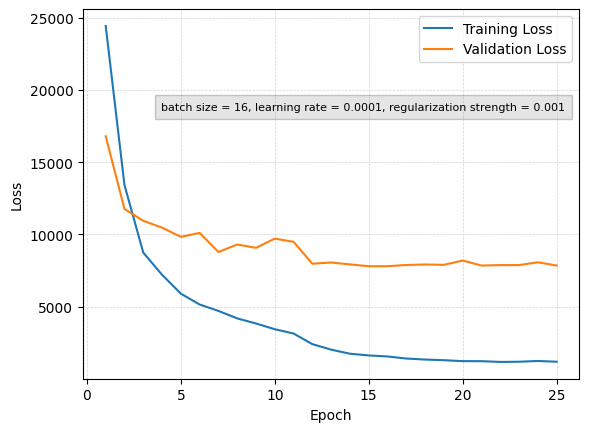

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(range(1, len(num_epochs)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(num_epochs)+1), val_losses, label='Validation Loss')

# Add gridlines as dashs
plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Learning Curve during Model Training for the Final Model\n', fontweight='bold')
plt.legend()

# Add subtitle
hyperparameters = f'batch size = 16, learning rate = 0.0001, regularization strength = 0.001'
plt.figtext(0.563, 0.67, hyperparameters, ha='center', fontsize=8, bbox={'facecolor':'gray', 'alpha':0.2, 'pad':5})

# Save the plot as a png file
plt.savefig('./figures/learning_curve.png', bbox_inches='tight')

# Display the plot
plt.show()

# Step 5: Prediction

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the path to the directory containing the test satellite image patches
test_sat_dir = data_dir + 'test/sat_patches'

# Set the path to the directory containing the corresponding test population patches
test_pop_dir = data_dir + 'test/pop_patches'

# Get the file paths of the satellite image patches for testing
test_paths = [os.path.join(test_sat_dir, file_name) for file_name in os.listdir(test_sat_dir) if file_name.endswith('.npy')]

# Sort the file paths to ensure that the order is consistent across runs
test_paths.sort()

# Load the satellite image patches and corresponding population patches for testing
test_X = []
test_y = []
for file_path in test_paths:
    # Load the satellite image patch
    sat_patch = np.load(file_path)
    # Reshape the input patch to have 3 channels
    sat_patch = np.transpose(sat_patch, (2, 0, 1)) # transpose to (channels, height, width)
    test_X.append(sat_patch)

    # Load the corresponding population patch
    pop_file_name = os.path.basename(file_path).replace('sat_patch', 'pop_patch')
    pop_path = os.path.join(test_pop_dir, pop_file_name)
    pop_patch = np.load(pop_path)
    # Reshape the target patch to have shape (1,)
    pop_patch = pop_patch.reshape(1, -1)
    test_y.append(pop_patch)

test_X = np.array(test_X)
test_y = np.array(test_y)

# Convert the testing data to PyTorch tensors
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()

# Move the testing data to the device
test_X = test_X.to(device)
test_y = test_y.to(device)

## 5.1 Evaluation metrics

In [ ]:
# Construct the filename of the saved model that had the best hyperparameters
model_name = "./resnet18_epochs_25_batch_size_16_lr_0.0001_reg_0.001.pth"

# Load the trained model
model = ResNet18()
model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(test_X).squeeze()

# Compute evaluation metrics
rmse = torch.sqrt(torch.mean((y_pred - test_y.squeeze())**2)).item()
mae = torch.mean(torch.abs(y_pred - test_y.squeeze())).item()
r2 = sklearn.metrics.r2_score(test_y.squeeze().cpu().numpy(), y_pred.cpu().numpy())

# Print evaluation metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 287MB/s]


RMSE: 22.9534
MAE: 15.6456
R-squared: 0.6664


In [ ]:
# Get the predicted population values for each city
city_names = ['kyiv', 'dnipro', 'lviv']
for city in city_names:
    city_mask = [f'{city}' in img_path for img_path in test_paths]
    city_test_X = test_X[city_mask]
    city_test_y = test_y[city_mask]

    with torch.no_grad():
        city_y_pred = model(city_test_X).cpu()
        city_test_y = city_test_y.cpu()

    # Move the tensors to the same device before performing any operations
    city_y_pred = city_y_pred.to(city_test_y.device)

    # Calculate the evaluation metrics for this city
    city_rmse = torch.sqrt(torch.mean((city_y_pred - city_test_y.squeeze())**2)).item()
    city_mae = torch.mean(torch.abs(city_y_pred - city_test_y.squeeze())).item()
    city_r2 = sklearn.metrics.r2_score(city_test_y.squeeze().cpu().numpy(), city_y_pred.squeeze().numpy())

    # Print evaluation metrics for this city
    print(f"Evaluation metrics for {city.title()}:")
    print(f"RMSE: {city_rmse:.4f}")
    print(f"MAE: {city_mae:.4f}")
    print(f"R-squared: {city_r2:.4f}")


Evaluation metrics for Kyiv:
RMSE: 51.5443
MAE: 38.0479
R-squared: 0.6743
Evaluation metrics for Dnipro:
RMSE: 40.0596
MAE: 26.2054
R-squared: 0.6058
Evaluation metrics for Lviv:
RMSE: 56.4892
MAE: 43.7119
R-squared: 0.6306


## 5.2 Predicted vs. true population values (scatter plots)

In [ ]:
# Construct the filename of the saved model that had the best hyperparameters
model_name = "./resnet18_epochs_25_batch_size_16_lr_0.0001_reg_0.001.pth"

# Load the trained model
model = ResNet18()
model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
model.to(device)

# Set the model to evaluation mode
model.eval()

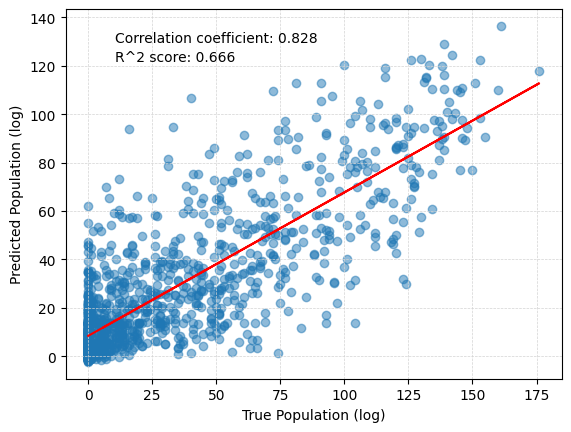

In [ ]:
# Get the predicted population values
with torch.no_grad():
    y_pred = model(test_X).cpu()

# Calculate the correlation coefficient and R^2 score
corr_coeff = np.corrcoef(test_y.squeeze().cpu().numpy(), y_pred.squeeze().numpy())[0, 1]
r2 = sklearn.metrics.r2_score(test_y.squeeze().cpu().numpy(), y_pred.squeeze().numpy())

# Create a scatter plot of predicted and true population values
plt.scatter(test_y.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.5)
plt.xlabel('True Population (log)')
plt.ylabel('Predicted Population (log)')
# plt.title('Predicted vs. True Population Counts (Total Study Area)\n', fontweight='bold')

# Add gridlines as dashs
plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

# Add a regression line to the scatter plot
fit = np.polyfit(test_y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten(), deg=1)
plt.plot(test_y.cpu().numpy().flatten(), fit[0] * test_y.cpu().numpy().flatten() + fit[1], color='red')

# Add the correlation coefficient and R^2 score to the plot
plt.text(0.1, 0.91, f'Correlation coefficient: {corr_coeff:.3f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.86, f'R^2 score: {r2:.3f}', transform=plt.gca().transAxes)

# Save the plot as a png file
plt.savefig('./figures/ScatterPlot_Predictions_all.png', bbox_inches='tight')

plt.show()


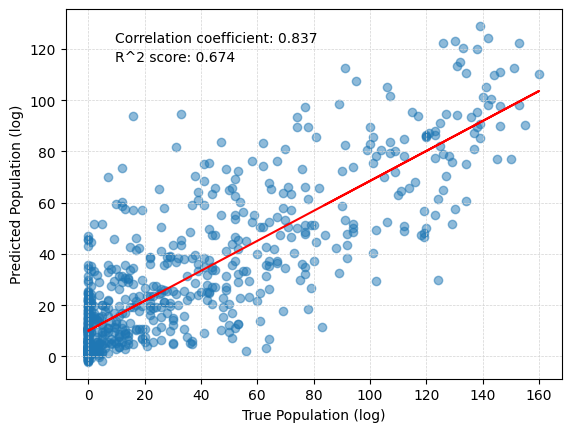

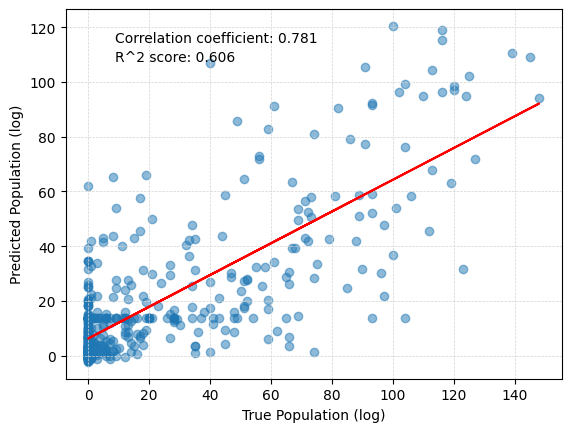

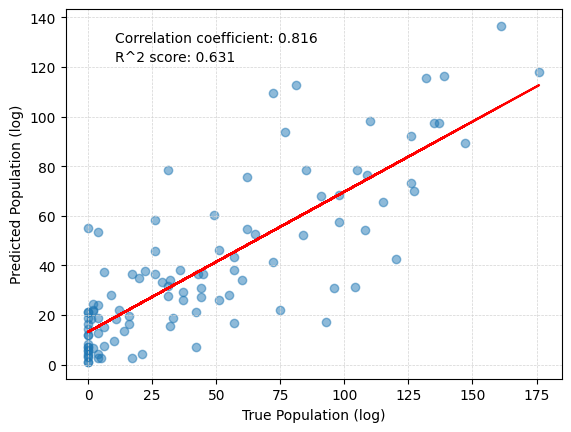

In [ ]:
# Get the predicted population values for each city
city_names = ['kyiv', 'dnipro', 'lviv']
for city in city_names:
    city_mask = [f'{city}' in img_path for img_path in test_paths]
    city_test_X = test_X[city_mask]
    city_test_y = test_y[city_mask]

    with torch.no_grad():
        city_y_pred = model(city_test_X).cpu()

    # Calculate the correlation coefficient and R^2 score for this city
    corr_coeff = np.corrcoef(city_test_y.squeeze().cpu().numpy(), city_y_pred.squeeze().numpy())[0, 1]
    r2 = sklearn.metrics.r2_score(city_test_y.squeeze().cpu().numpy(), city_y_pred.squeeze().numpy())

    # Create a scatter plot of predicted and true population values for this city
    plt.scatter(city_test_y.cpu().numpy(), city_y_pred.cpu().numpy(), alpha=0.5)
    plt.xlabel('True Population (log)')
    plt.ylabel('Predicted Population (log)')
    # plt.title(f'Predicted vs. True Population Counts for {city.title()}\n', fontweight='bold')

    # Add gridlines as dashs
    plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

    # Add a regression line to the scatter plot
    fit = np.polyfit(city_test_y.cpu().numpy().flatten(), city_y_pred.cpu().numpy().flatten(), deg=1)
    plt.plot(city_test_y.cpu().numpy().flatten(), fit[0] * city_test_y.cpu().numpy().flatten() + fit[1], color='red')

    # Add the correlation coefficient and R^2 score to the plot
    plt.text(0.1, 0.91, f'Correlation coefficient: {corr_coeff:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.86, f'R^2 score: {r2:.3f}', transform=plt.gca().transAxes)

    plt.savefig(f'./figures/ScatterPlot_Predictions_{city}.png', bbox_inches='tight')
    plt.show()


## 5.3 Testing for bias

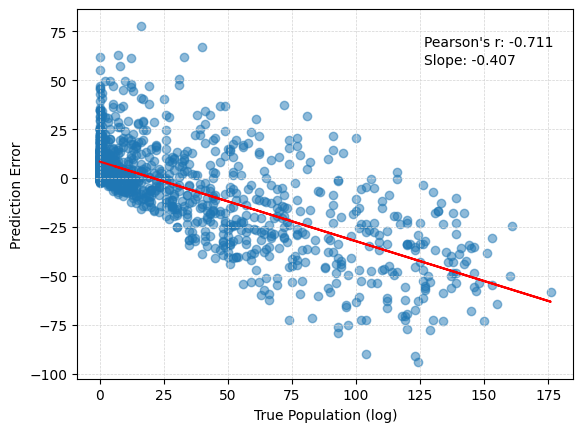

In [ ]:
# Get the predicted population values
with torch.no_grad():
    y_pred = model(test_X).cpu()

# Calculate the prediction errors
y_error = y_pred.squeeze().numpy() - test_y.squeeze().cpu().numpy()

# Calculate the Pearson's r value
r, _ = scipy.stats.pearsonr(test_y.squeeze().cpu().numpy(), y_error)

# Create a scatter plot of prediction errors against true population values
plt.scatter(test_y.squeeze().cpu().numpy(), y_error, alpha=0.5)
plt.xlabel('True Population (log)')
plt.ylabel('Prediction Error')
# plt.title('Prediction Error vs. True Population Counts (Total Study Area)\n', fontweight='bold')

# Add gridlines as dashs
plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

# Add a regression line to the scatter plot
fit = np.polyfit(test_y.squeeze().cpu().numpy().flatten(), y_error.flatten(), deg=1)
plt.plot(test_y.squeeze().cpu().numpy().flatten(), fit[0] * test_y.squeeze().cpu().numpy().flatten() + fit[1], color='red')

# Add the Pearson's r value and slope to the plot
plt.text(0.7, 0.9, f'Pearson\'s r: {r:.3f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.85, f'Slope: {fit[0]:.3f}', transform=plt.gca().transAxes)

# Save the plot as a png file
plt.savefig('./figures/ScatterPlot_PredictionError.png', bbox_inches='tight')

plt.show()


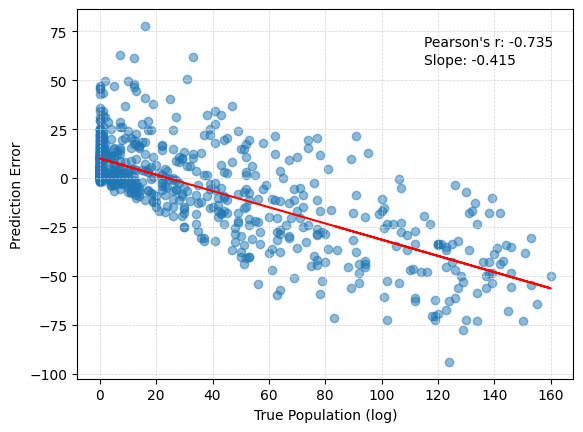

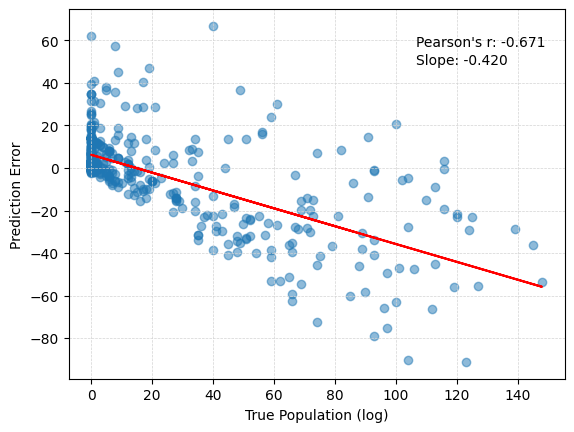

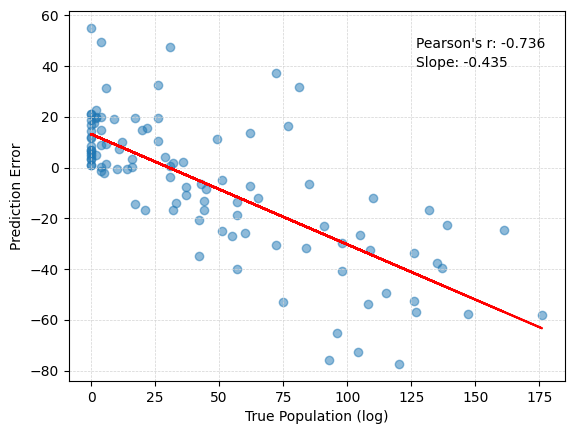

In [ ]:
# Get the predicted population values and calculate the prediction errors for each city
city_names = ['kyiv', 'dnipro', 'lviv']
for city in city_names:
    city_mask = [f'{city}' in img_path for img_path in test_paths]
    city_test_X = test_X[city_mask]
    city_test_y = test_y[city_mask]

    with torch.no_grad():
        city_y_pred = model(city_test_X).cpu()

    # Calculate the prediction errors for this city
    city_y_error = city_y_pred.squeeze().numpy() - city_test_y.squeeze().cpu().numpy()

    # Calculate the Pearson's r value for this city
    r, _ = scipy.stats.pearsonr(city_test_y.squeeze().cpu().numpy(), city_y_error)

    # Create a scatter plot of prediction errors against true population values for this city
    plt.scatter(city_test_y.squeeze().cpu().numpy(), city_y_error, alpha=0.5)
    plt.xlabel('True Population (log)')
    plt.ylabel('Prediction Error')
    # plt.title(f'Prediction Error vs. True Population Counts for {city.title()} \n', fontweight='bold')

    # Add gridlines as dashs
    plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

    # Add a regression line to the scatter plot
    fit = np.polyfit(city_test_y.squeeze().cpu().numpy().flatten(), city_y_error.flatten(), deg=1)
    plt.plot(city_test_y.squeeze().cpu().numpy().flatten(), fit[0] * city_test_y.squeeze().cpu().numpy().flatten() + fit[1], color='red')

    # Add the Pearson's r value and slope to the plot
    plt.text(0.7, 0.9, f'Pearson\'s r: {r:.3f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.85, f'Slope: {fit[0]:.3f}', transform=plt.gca().transAxes)

    plt.savefig(f'./figures/ScatterPlot_PredictionError_{city}.png', bbox_inches='tight')
    plt.show()


## 5.4 Transferability experiment

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the path to the directory containing the test satellite image patches
test_sat_dir = '../../data/PatchesTransferability/sat_patches'

# Set the path to the directory containing the corresponding test population patches
test_pop_dir = '../../data/PatchesTransferability/pop_patches'

# Get the file paths of the satellite image patches for testing
test_paths = [os.path.join(test_sat_dir, file_name) for file_name in os.listdir(test_sat_dir) if file_name.endswith('.npy')]

# Sort the file paths to ensure that the order is consistent across runs
test_paths.sort()

# Load the satellite image patches and corresponding population patches for testing
test_X = []
test_y = []
for file_path in test_paths:
    # Load the satellite image patch
    sat_patch = np.load(file_path)
    # Reshape the input patch to have 3 channels
    sat_patch = np.transpose(sat_patch, (2, 0, 1)) # transpose to (channels, height, width)
    test_X.append(sat_patch)

    # Load the corresponding population patch
    pop_file_name = os.path.basename(file_path).replace('sat_patch', 'pop_patch')
    pop_path = os.path.join(test_pop_dir, pop_file_name)
    pop_patch = np.load(pop_path)
    # Reshape the target patch to have shape (1,)
    pop_patch = pop_patch.reshape(1, -1)
    test_y.append(pop_patch)

test_X = np.array(test_X)
test_y = np.array(test_y)

# Convert the testing data to PyTorch tensors
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()

# Move the testing data to the device
test_X = test_X.to(device)
test_y = test_y.to(device)

In [ ]:
# Construct the filename of the saved model that had the best hyperparameters
model_name = "./resnet18_epochs_25_batch_size_16_lr_0.0001_reg_0.001.pth"

# Load the trained model
model = ResNet18()
model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(test_X).squeeze()

# Compute evaluation metrics
rmse = torch.sqrt(torch.mean((y_pred - test_y.squeeze())**2)).item()
mae = torch.mean(torch.abs(y_pred - test_y.squeeze())).item()
r2 = sklearn.metrics.r2_score(test_y.squeeze().cpu().numpy(), y_pred.cpu().numpy())

# Print evaluation metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


RMSE: 31.3595
MAE: 24.1412
R-squared: -0.1245


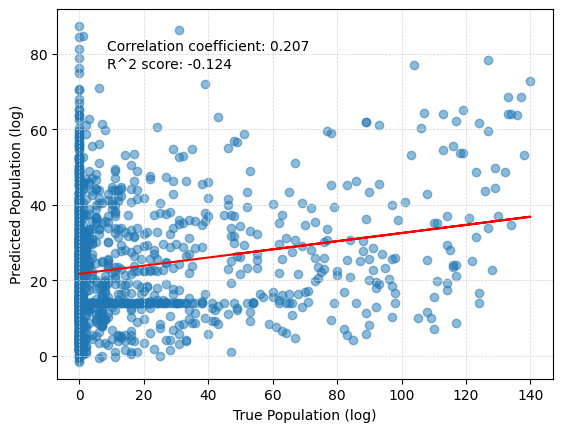

In [ ]:
# Get the predicted population values
with torch.no_grad():
    y_pred = model(test_X).cpu()

# Calculate the correlation coefficient and R^2 score
corr_coeff = np.corrcoef(test_y.squeeze().cpu().numpy(), y_pred.squeeze().numpy())[0, 1]
r2 = sklearn.metrics.r2_score(test_y.squeeze().cpu().numpy(), y_pred.squeeze().numpy())

# Create a scatter plot of predicted and true population values
plt.scatter(test_y.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.5)
plt.xlabel('True Population (log)')
plt.ylabel('Predicted Population (log)')
# plt.title('Predicted vs. True Population Counts (Vinnytsia)\n', fontweight='bold')

# Add gridlines as dashs
plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

# Add a regression line to the scatter plot
fit = np.polyfit(test_y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten(), deg=1)
plt.plot(test_y.cpu().numpy().flatten(), fit[0] * test_y.cpu().numpy().flatten() + fit[1], color='red')

# Add the correlation coefficient and R^2 score to the plot
plt.text(0.1, 0.89, f'Correlation coefficient: {corr_coeff:.3f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.84, f'R^2 score: {r2:.3f}', transform=plt.gca().transAxes)

# Save the plot as a png file
plt.savefig('./figures/ScatterPlot_Predictions_vinnytsia.png', bbox_inches='tight')

plt.show()


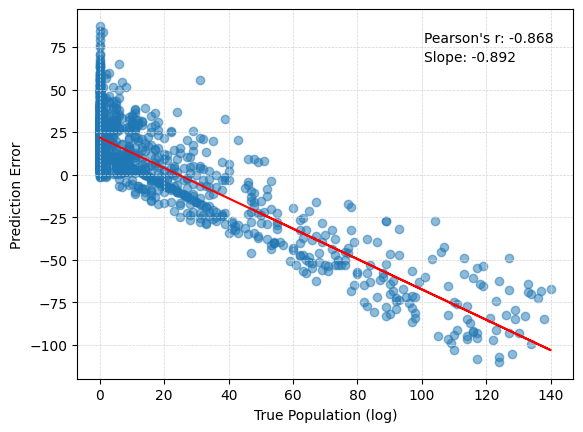

In [ ]:
# Get the predicted population values
with torch.no_grad():
    y_pred = model(test_X).cpu()

# Calculate the prediction errors
y_error = y_pred.squeeze().numpy() - test_y.squeeze().cpu().numpy()

# Calculate the Pearson's r value
r, _ = scipy.stats.pearsonr(test_y.squeeze().cpu().numpy(), y_error)

# Create a scatter plot of prediction errors against true population values
plt.scatter(test_y.squeeze().cpu().numpy(), y_error, alpha=0.5)
plt.xlabel('True Population (log)')
plt.ylabel('Prediction Error')
# plt.title('Prediction Error vs. True Population Counts (Vinnytsia)\n', fontweight='bold')

# Add gridlines as dashs
plt.grid(color='lightgrey', linestyle='dashed', linewidth=0.5)

# Add a regression line to the scatter plot
fit = np.polyfit(test_y.squeeze().cpu().numpy().flatten(), y_error.flatten(), deg=1)
plt.plot(test_y.squeeze().cpu().numpy().flatten(), fit[0] * test_y.squeeze().cpu().numpy().flatten() + fit[1], color='red')

# Add the Pearson's r value and slope to the plot
plt.text(0.7, 0.91, f'Pearson\'s r: {r:.3f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.86, f'Slope: {fit[0]:.3f}', transform=plt.gca().transAxes)

# Save the plot as a png file
plt.savefig('./figures/ScatterPlot_PredictionError_Vinnytsia.png', bbox_inches='tight')

plt.show()
